In [21]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import astropy.visualization as vis

from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service
from lsst.source.injection import generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.ip.diffim.subtractImages import AlardLuptonSubtractTask, AlardLuptonSubtractConfig
from lsst.ip.diffim.detectAndMeasure import DetectAndMeasureTask, DetectAndMeasureConfig

In [22]:
# defines a few utilities we built in the last notebook..
def query_and_table(service, query):
    return service.search(query).to_table()


def table_summary(service, table_name: str):
    s = ""
    description = service.search(
        "SELECT description "
        "FROM tap_schema.tables "
        "WHERE tap_schema.tables.schema_name = 'dp02_dc2_catalogs'" 
        f"AND table_name = 'dp02_dc2_catalogs.{table_name}'"
    ).to_table().to_pandas().iloc[0]["description"]
    s += f"{table_name}: {description}\n\n"
    for i, row in service.search(
            "SELECT column_name, datatype, description, unit "
            "FROM tap_schema.columns "
            f"WHERE table_name = 'dp02_dc2_catalogs.{table_name}'"
        ).to_table().to_pandas().iterrows():
        s += f"{row.column_name}:  {row.description} ({row.datatype})\n"
    return s
        

def sregion_to_vertices(sregion: str, closed=True):
    """Convert the s_region from the ObsCore table into two
    arrays containing the x and y vertices, in order to plot
    boxes using matplotlib.

    from notebook DPO02_02c.
    """
    temp = sregion.split(' ')
    xvertices = []
    yvertices = []
    ix = 2
    iy = 3
    for c in range(4):
        xvertices.append(float(temp[ix]))
        yvertices.append(float(temp[iy]))
        ix += 2
        iy += 2
    if closed:
        xvertices.append(xvertices[0])
        yvertices.append(yvertices[0])
    return xvertices, yvertices


def circle_string(ra, dec, err_radius):
    return f"{ra:.4f}, {dec:.4f}, {err_radius:.4f}"


def query_obs_stdomain(service, tstart_mj, tstop_mj, ra, dec, err_radius, dp_subtype="lsst.calexp"):
    """
    Queries observation table for all pictures of type `dp_subtype` taken between 
    start_mj and stop_mj, with central spatial position falling in a circle centered
    at `ra`, `dec` with radius `err_radius`.
    """
    return query_and_table(
        service, 
        "SELECT *"
        "FROM ivoa.ObsCore "
        f"WHERE CONTAINS(POINT('ICRS', s_ra, s_dec), CIRCLE('ICRS', {circle_string(ra, dec, err_radius)}))=1 "
        f"AND t_min >= {tstart_mj} "
        f"AND t_min < {tstop_mj} "
        f"AND dataproduct_subtype = '{dp_subtype}'"
    ).to_pandas()


service = get_tap_service("tap")

## In previous episodes: source injection and subtraction

In this section we recover some useful code and quantities we built in our notebook on source injection, 250508_injection.ipynb. In summary, we will define coordinate for a transient close to a nearby galaxy, inject the source and construct the image difference between the injected exposure and its template.

### Transient definition

In [23]:
coord_galhost = SkyCoord(
    ra = 56.922302 * u.degree, 
    dec = -33.948517 * u.degree,
)

In [24]:
coord_transient = SkyCoord(
    ra = coord_galhost.ra - 1.3 * u.arcmin,
    dec = coord_galhost.dec, 
    frame='icrs'
)
mag_transient = 17.

In [25]:
dataId = {
    "instrument": "LSSTCam-imSim",
    "detector": 60,
    "visit": 964209,
    "band": "r",
    "physical_filter": "r_sim_1.4",
}

butler = Butler('dp02', collections='2.2i/runs/DP0.2')
calexp = butler.get("calexp", dataId=dataId)

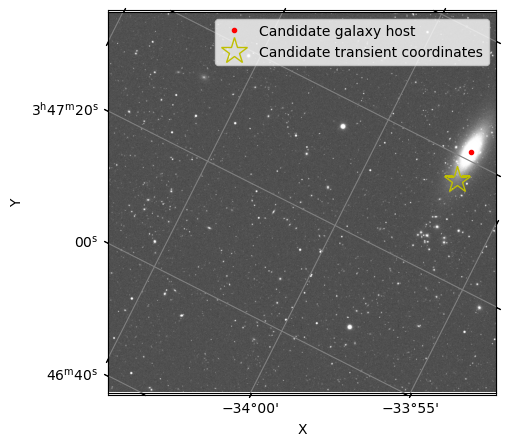

In [26]:
# plots the base image
img_wcs = WCS(calexp.getWcs().getFitsMetadata())
image_data = calexp.getImage().array
zscale = vis.ZScaleInterval()

fig, ax = plt.subplots(1, figsize=(5, 5))
plt.subplot(projection=img_wcs)
plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'ro', ms=3, label="Candidate galaxy host")
plt.plot(*img_wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Candidate transient coordinates")
limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
plt.imshow(image_data, cmap='gray', **limits)
plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
plt.grid(color='grey', ls='solid')
plt.legend()
plt.show()

### Source injection

In [27]:
def inject_star_source(calexp, ra, dec, mag):
    EPSILON = 10**-7
    injection_catalog = generate_injection_catalog(
        ra_lim=[ra, ra + EPSILON],
        dec_lim=[dec, dec + EPSILON],
        number=1,
        source_type="Star",
        mag=[mag],
    )
    inject_config = VisitInjectConfig()
    inject_task = VisitInjectTask(config=inject_config)
    injected_output = inject_task.run(
        injection_catalogs=injection_catalog,
        input_exposure=calexp.clone(),
        psf=calexp.getPsf(),
        photo_calib=calexp.getPhotoCalib(),
        wcs=calexp.getWcs(),
    )
    return injected_output.output_exposure, injected_output.output_catalog

calexp_injected, calexp_catalog = inject_star_source(calexp, coord_transient.ra.deg, coord_transient.dec.deg, mag_transient)

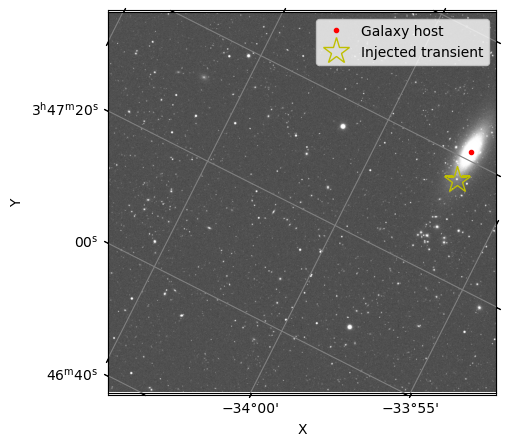

In [28]:
# plots the image with injected source
img_wcs = WCS(calexp_injected.getWcs().getFitsMetadata())
image_data = calexp_injected.getImage().array
zscale = vis.ZScaleInterval()

fig, ax = plt.subplots(1, figsize=(5, 5))
plt.subplot(projection=img_wcs)
plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'ro', ms=3, label="Galaxy host")
plt.plot(*img_wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Injected transient")
limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
plt.imshow(image_data, cmap='gray', **limits)
plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
plt.grid(color='grey', ls='solid')
plt.legend()
plt.show()

### Image subtraction

In [29]:
sources = butler.get('src', dataId=dataId)
template = butler.get("goodSeeingDiff_templateExp", dataId=dataId)

config = AlardLuptonSubtractConfig()
config.sourceSelector.value.unresolved.name = 'base_ClassificationExtendedness_value'
alTask = AlardLuptonSubtractTask(config=config)
difference = alTask.run(template, calexp_injected, sources)
calexp_difference = difference.difference

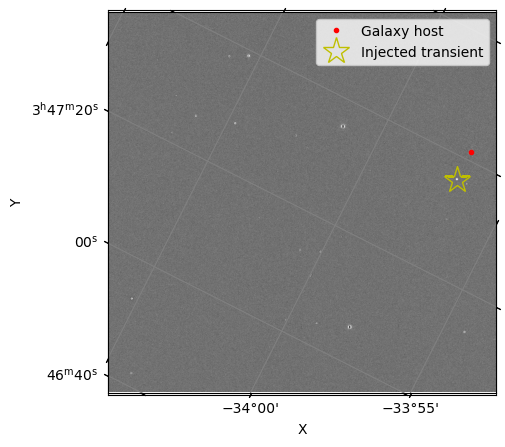

In [30]:
# plots the image difference
img_wcs = WCS(calexp_difference.getWcs().getFitsMetadata())
image_data = calexp_difference.getImage().array
zscale = vis.ZScaleInterval()

fig, ax = plt.subplots(1, figsize=(5, 5))
plt.subplot(projection=img_wcs)
plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'ro', ms=3, label="Galaxy host")
plt.plot(*img_wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Injected transient")
limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
plt.imshow(image_data, cmap='gray', **limits)
plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
plt.grid(color='grey', ls='solid')
plt.legend()
plt.show()

# Difference Image Analysis

The official tutorial notebook on source detection is weird. It does not work with difference images, so I'm wondering if we should be working with these at all. However, the `diffim` package from the LSST pipeline contains routines for source detection on difference image, see [this](https://github.com/lsst/ip_diffim/blob/main/python/lsst/ip/diffim/detectAndMeasure.py) page. They are scarcely documented but usable. Let's try to use it.

In [31]:
config = DetectAndMeasureConfig()
# the next line should select only positive sources but it's causing an error. maybe open an issue
# config.detection.thresholdPolarity = "positive"
results = DetectAndMeasureTask(config=config).run(calexp_injected, template, calexp_difference)

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


This is an excerpt of what we got:

In [32]:
diaSources_lg_df = results.getDict()["diaSources"].asAstropy().to_pandas()
diaSources_lg_df.head()

,id,coord_ra,coord_dec,parent,coord_raErr,coord_decErr,coord_ra_dec_Cov,is_negative,detect_isPrimary,base_SdssCentroid_x,...,ip_diffim_forced_PsfFlux_instFlux,ip_diffim_forced_PsfFlux_instFluxErr,ip_diffim_forced_PsfFlux_area,ip_diffim_forced_PsfFlux_flag,ip_diffim_forced_PsfFlux_flag_noGoodPixels,ip_diffim_forced_PsfFlux_flag_edge,refMatchId,srcMatchId,merge_footprint_positive,merge_footprint_negative
0,2,0.990230,-0.593444,0,1.677370e-07,2.116839e-07,2.202666e-15,False,False,1698.243286,...,2.124575e+05,691.254482,39.299316,False,False,False,0,0,True,False
1,3,0.991558,-0.591437,0,NaN,NaN,NaN,False,False,4051.014703,...,9.991816e+05,1471.735544,40.325058,True,False,True,0,0,True,True
2,4,0.989463,-0.594899,0,NaN,NaN,NaN,False,False,60.956102,...,1.288210e+06,1667.573170,39.480297,False,False,False,0,0,True,True
3,8,0.990936,-0.592827,0,2.626514e-07,3.219142e-07,1.931307e-15,False,False,2538.079052,...,1.473513e+03,234.013463,39.561092,False,False,False,0,0,True,False
4,11,0.991245,-0.593396,0,NaN,NaN,NaN,False,False,2127.223634,...,2.706374e+04,263.494417,39.505527,False,False,False,0,0,True,True


The table is huge and contains many columns of dubious value. Some of the column values needs conversion. We fix it.

In [33]:
_df = diaSources_lg_df
_df = _df[~_df["is_negative"]]
diaSources_df = pd.DataFrame(
    {
        "coord_ra": np.rad2deg(_df["coord_ra"]),
        "coord_dec": np.rad2deg(_df["coord_dec"]),
        "PsfFlux": _df["base_PsfFlux_instFlux"],
        "PsfFlux_Err": _df["base_PsfFlux_instFluxErr"],
        "mag": -2.5 * np.log10(_df["ip_diffim_forced_PsfFlux_instFlux"]) + 31.4,
        "snr": _df["base_PsfFlux_instFlux"] / _df["base_PsfFlux_instFluxErr"]
    }
)

In [34]:
diaSources_df.sort_values("snr", ascending=False)

,coord_ra,coord_dec,PsfFlux,PsfFlux_Err,mag,snr
11,56.900635,-33.948517,1.179248e+06,1584.580981,16.214777,744.201910
13,56.878835,-33.995991,8.855178e+04,2130.106398,15.612664,41.571531
10,56.900941,-33.942121,8.397084e+04,2203.335160,15.557015,38.110789
19,56.864645,-34.116765,2.861801e+04,2062.766255,15.684981,13.873609
0,56.735974,-34.001814,6.502495e+03,697.263491,18.081820,9.325735
20,56.880746,-34.135867,2.311122e+03,250.189110,22.154416,9.237499
18,56.891068,-34.033815,1.221150e+03,235.701078,23.697228,5.180926
3,56.776472,-33.966500,1.195568e+03,235.841299,23.479115,5.069374
8,56.848849,-34.007802,2.099257e+03,420.567702,19.390224,4.991484
14,56.873320,-34.034913,3.706453e+03,747.289025,17.616438,4.959866


One weird thing: even if the configuration threshold is set to 5 sigma we got a lot of sources with snr between -5 and +5. Why?

In [35]:
config.detection.thresholdValue

5.0

We can see that the detected source with the highest SNR (first in the table above)  is at the injected transient location which is cool. The magnitude however is a bit off: why? How do we get better estimates?

Now let's plot what we got onto the difference image.

In [36]:
coord_transient, mag_transient

(<SkyCoord (ICRS): (ra, dec) in deg
     (56.90063533, -33.948517)>,
 17.0)

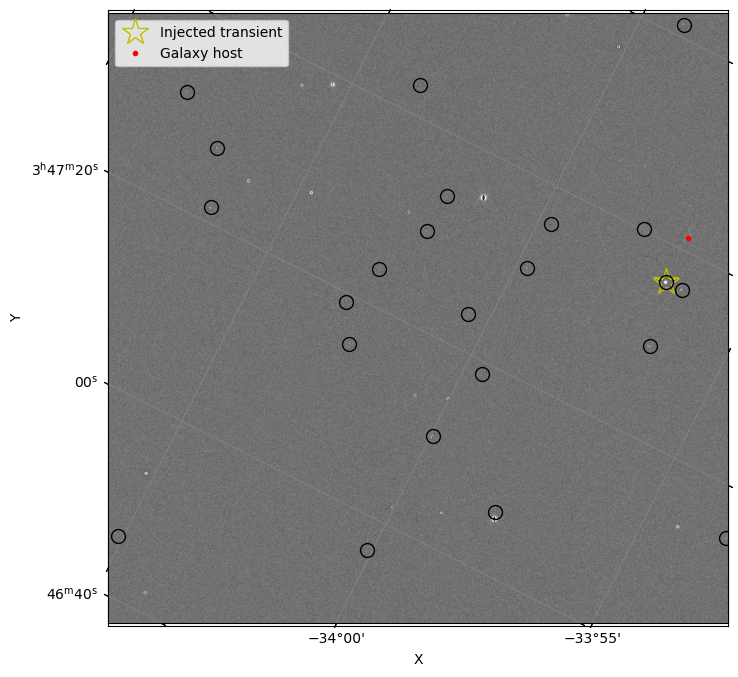

In [37]:
# plots the image difference with overlayed reconstructed sources
img_wcs = WCS(calexp_difference.getWcs().getFitsMetadata())
image_data = calexp_difference.getImage().array
zscale = vis.ZScaleInterval()

fig, ax = plt.subplots(1, figsize=(8, 8))
plt.subplot(projection=img_wcs)
plt.imshow(image_data, cmap='gray', **limits)
plt.plot(*img_wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Injected transient")
plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'ro', ms=3, label="Galaxy host")
for _, source in diaSources_df.iterrows():
    coord_source = SkyCoord(
        ra = source["coord_ra"] * u.deg,
        dec = source["coord_dec"] * u.deg,
        frame='icrs'
    )
    plt.plot(*img_wcs.world_to_pixel(coord_source), 'ko', markerfacecolor="None", ms=10)

limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
plt.grid(color='grey', ls='solid')
plt.legend()
plt.show()

We can select only sources with snr > 4 of course.

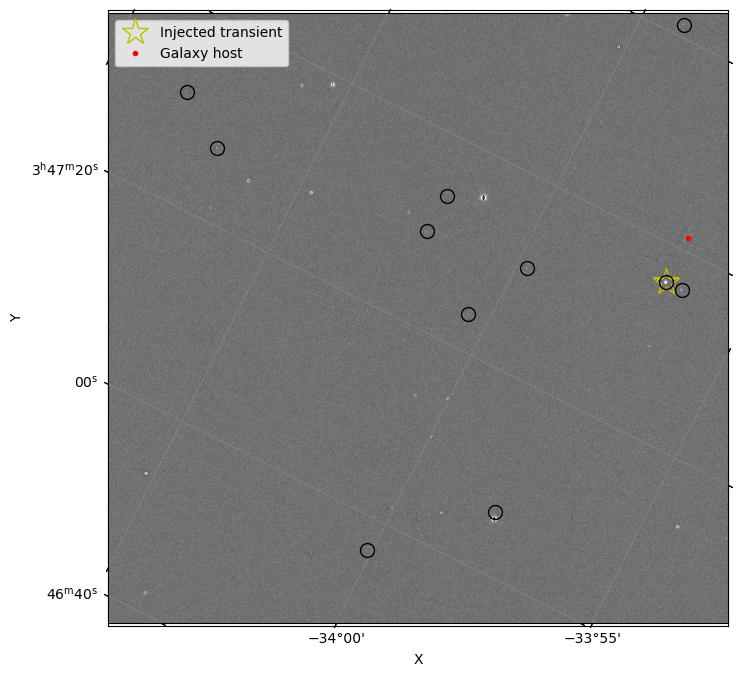

In [38]:
# plots the image difference with overlayed reconstructed sources above snr threshold
threshold = 4.0
img_wcs = WCS(calexp_difference.getWcs().getFitsMetadata())
image_data = calexp_difference.getImage().array
zscale = vis.ZScaleInterval()

fig, ax = plt.subplots(1, figsize=(8, 8))
plt.subplot(projection=img_wcs)
plt.imshow(image_data, cmap='gray', **limits)
plt.plot(*img_wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Injected transient")
plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'ro', ms=3, label="Galaxy host")
for _, source in diaSources_df[diaSources_df["snr"] > threshold].iterrows():
    coord_source = SkyCoord(
        ra = source["coord_ra"] * u.deg,
        dec = source["coord_dec"] * u.deg,
        frame='icrs'
    )
    plt.plot(*img_wcs.world_to_pixel(coord_source), 'ko', markerfacecolor="None", ms=10)

limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
plt.grid(color='grey', ls='solid')
plt.legend()
plt.show()

There are few bright points that are not detected. Are these near stars? Let's try to gather them from catalog and overplot to our detections.

In [98]:
s_region = "POLYGON ICRS 56.772371 -33.853414 56.633431 -34.079736 56.902664 -34.193001 57.041067 -33.966365"
query = ("SELECT mt.id_truth_type AS mt_id_truth_type, "
        "mt.match_objectId AS mt_match_objectId, "
        "ts.ra AS ts_ra, "
        "ts.dec AS ts_dec, "
        "ts.mag_r AS ts_mag_r, "
        "ts.redshift AS ts_redshift, "
        "ts.flux_r AS ts_flux_r, "
        "obj.coord_ra AS obj_coord_ra, "
        "obj.coord_dec AS obj_coord_dec, "
        "obj.refExtendedness AS obj_refExtendedness, "
        "scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_cModelMag_r, "
        "obj.r_cModelFlux AS obj_r_cModelFlux "
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "
        "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId "
        "WHERE CONTAINS(POINT('ICRS', obj.coord_ra, obj.coord_dec), POLYGON('ICRS', 56.772371, -33.853414, 56.633431, -34.079736, 56.902664, -34.193001, 57.041067, -33.966365)) = 1 "
        "AND ts.truth_type = 2 "  # stars have type 2
        "AND obj.detect_isPrimary = 1 "
        "AND ts.mag_r < 22")

stars_true_df = query_and_table(service, query).to_pandas()

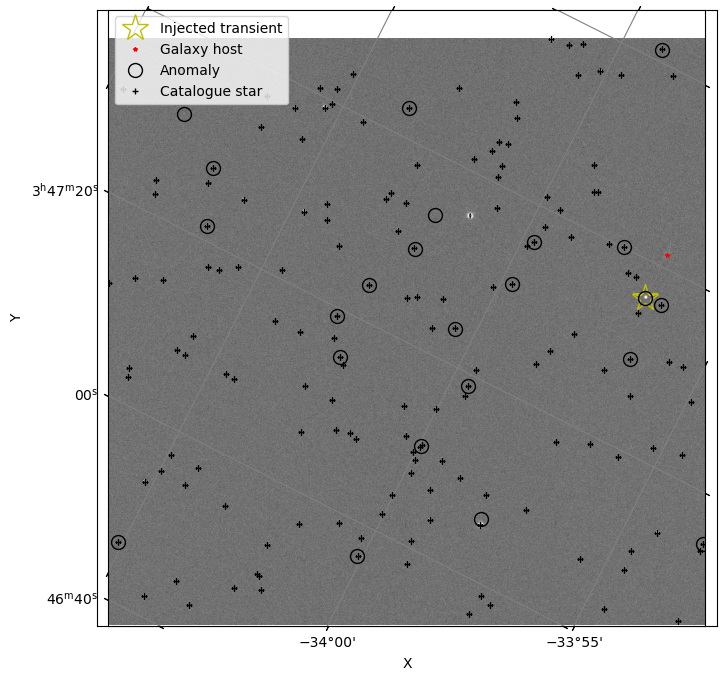

In [99]:
# plots the image difference with overlayed sources and catalog stars
img_wcs = WCS(calexp_difference.getWcs().getFitsMetadata())
image_data = calexp_difference.getImage().array
zscale = vis.ZScaleInterval()

fig, ax = plt.subplots(1, figsize=(8, 8))
plt.subplot(projection=img_wcs)
plt.imshow(image_data, cmap='gray', **limits)
plt.plot(*img_wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Injected transient")
plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'r*', ms=3, label="Galaxy host")

printed_label = False
for _, source in diaSources_df.iterrows():
    coord_source = SkyCoord(
        ra = source["coord_ra"] * u.deg,
        dec = source["coord_dec"] * u.deg,
        frame='icrs'
    )
    plt.plot(*img_wcs.world_to_pixel(coord_source), 'ko', markerfacecolor="None", ms=10, label="Anomaly" if not printed_label else "")
    printed_label = True
    
printed_label = False
for _, star in stars_true_df.iterrows():
    if not calexp.containsSkyCoords(star["ts_ra"] * u.deg, star["ts_dec"] * u.deg):
        continue
    coord_source = SkyCoord(
        ra = star["ts_ra"] * u.deg,
        dec = star["ts_dec"] * u.deg,
        frame='icrs'
    )
    plt.plot(*img_wcs.world_to_pixel(coord_source), 'k+', markerfacecolor="None", ms=5, label="Catalogue star" if not printed_label else "")
    printed_label = True
    
limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
plt.grid(color='grey', ls='solid')
plt.legend(loc = "upper left")
plt.show()

It seems that most of the detection we made overlap with some catalogue star. If stars were indeed responsible for some of our detection, why we don't seem to catch them all?